# Analysis framework for rotation period extraction 

This notebook provide an example of a full composite analysis similar to what will be performed by the PLATO pipeline: results from Lomb-Scargle periodogram, autocorrelation functions and composite spectrum are used to produce a set of features exploited by an existing instance of ROOSTER to return the final rotation period of the analysed target. You will find that what is done here is very similar to the ROOSTER tutorial notebook (`rooster_training_framework`, you should run it before doing this tutorial), the only big difference is actually that we will use here a pre-trained ROOSTER instance !

In [1]:
import star_privateer as sp

In [2]:
sp.__version__

'1.2.0'

## A simple example

In [3]:
import os, pathos
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

if not os.path.exists ('stellar_analysis_features') :
    os.mkdir ('stellar_analysis_features')  

Our working case is KIC 3733735, a well-known *Kepler* fast rotating star.

In [4]:
filename = sp.get_target_filename (sp.timeseries, '003733735')
t, s, dt = sp.load_resource (filename)

The first thing we have to do is run the analysis pipeline. In particular, we can take a look at the plots made from the different analysis methods. 

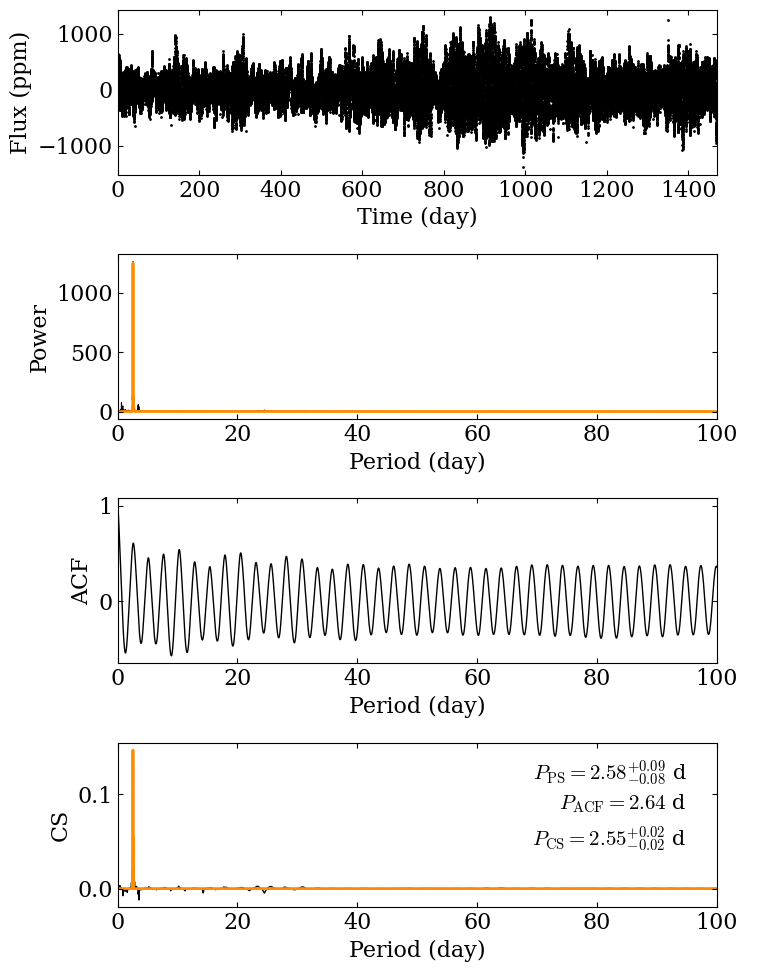

In [5]:
(p_ps, p_acf, ps, acf, 
 cs, features, feature_names, _) = sp.analysis_pipeline (t, s, pmin=0.1, pmax=60, figsize=(8,10),
                                                            wavelet_analysis=False, plot=True,
                                                            filename='stellar_analysis_features/003733735.png',
                                                        )

We then save the results to a csv file:

In [6]:
fileout = 'stellar_analysis_features/003733735.csv'
df = sp.save_features (fileout, 3733735, features, feature_names)

As in the previous tutorial, let's build a feature catalog. This is actually not required here because we are analysing only one star, but this step allows to ROOSTER-analyse several stars together with a simple framework.

In [7]:
df = sp.build_catalog_features ('stellar_analysis_features')

Then, let's load the ROOSTER instance that we have trained in the previous tutorial:

In [8]:
chicken = sp.load_rooster_instance (filename='rooster_instances/rooster_tutorial')

As previously, let's split the DataFrame into ROOSTER required inputs:

In [9]:
(target_id, p_candidates, 
 e_p_candidates, E_p_candidates, 
 features, feature_names) = sp.create_rooster_feature_inputs (df, return_err=True)

Here, we can see that there is actually (almost) nothing to do, as the three methods have yielded the same $P_\mathrm{rot}$ estimate. However, we need ROOSTER to provide us with the rotation score of the target. ROOSTER will also select one of the three ``p_candidates`` as the final estimate for our target.

In [10]:
p_candidates

array([[2.58380358, 2.63594132, 2.55499949]])

The ``analyseSet`` function implemented in ROOSTER allows to analyse the features we extracted with the analysis pipeline. By providing ``feature_names``, we ensure that ROOSTER was trained with the same features that those we extracted.

In [11]:
rotation_score, prot, e_p, E_p = chicken.analyseSet (features, p_candidates, e_p_err=e_p_candidates,
                                                     E_p_err=E_p_candidates, feature_names=feature_names)

We finally get the rotation score and the final $P_\mathrm{rot}$. A rotation score above 0.5 means that the ROOSTER analysis favours a detection of stellar surface rotation signal.

In [12]:
rotation_score, prot, e_p, E_p

(array([0.71]), array([2.63594132]), array([-1.]), array([-1.]))

## Analysing a PLATO simulated light curves dataset

In order to illustrate the pipeline features described above, we can apply the pipeline to a larger dataset of 255 PLATO simulated light curves in order to check what we recover.

In [13]:
import plato_msap4_demonstrator_datasets.plato_sim_dataset as plato_sim_dataset

if not os.path.exists ('plato_sim_features') :
    os.mkdir ('plato_sim_features')

In [14]:
list_id = sp.get_list_targets (plato_sim_dataset)

Just as in the ROOSTER tutorial, we define a dedicated wrapper to analyse several light curves in parallel and avoid any memory leakage. Note than, we apply a 60-day high-pass finite impulse response filter to the simulated light curves (`preprocess`) function in order to remove low-frequency systematics while preserving at most the signature of stellar surface rotation in the data. 

In [15]:
def analysis_wrapper (star_id) :
    """
    Analysis wrapper to speed computation
    by parallelising process and control
    memory usage.
    """
    star_id = str (star_id).zfill (3)
    fileout = 'plato_sim_features/{}.csv'.format(star_id)
    fileplot = 'plato_sim_features/{}.png'.format(star_id)
    filename = sp.get_target_filename (plato_sim_dataset, star_id, filetype='csv')
    if not os.path.exists (fileout) :
        t, s, dt = sp.load_resource (filename)
        s = sp.preprocess (t, s, cut=60)
        (p_ps, p_acf, 
         ps, acf, 
         cs, features, 
         feature_names, fig) = sp.analysis_pipeline (t, s, pmin=0.1, pmax=60,
                                                     wavelet_analysis=False, plot=True,
                                                     filename=fileplot, figsize=(10,16), 
                                                     lw=1, dpi=150, pfa_threshold=1e-6,
                                                     ls_err_smooth=True)
        df = sp.save_features (fileout, star_id, features, feature_names)
        plt.close ("all")

Let's run the process pool:

In [16]:
process_pool = pathos.pools._ProcessPool (processes=4, 
                                          maxtasksperchild=10)
with process_pool as p :
    list (tqdm (p.imap (analysis_wrapper,
                        list_id,
                        ),
                total=len (list_id))
          )
    p.close ()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 255/255 [00:00<00:00, 682.08it/s]


We can now analyse the obtained features with ROOSTER to provide our final results.

In [17]:
df = sp.build_catalog_features ('plato_sim_features')
df

prot_ps   prot_acf    prot_cs  e_prot_ps  E_prot_ps  e_prot_acf  \
target_id                                                                      
0          43.401094  36.201157   0.561108   1.111270   1.111270        -1.0   
1           0.190075  32.603958   0.168332   0.075331   0.075331        -1.0   
2          17.351053  18.062384  17.303959   1.866079   1.866079        -1.0   
3          21.034984  20.791534  20.915795   0.863260   0.863260        -1.0   
4           0.104212  28.770649   0.203401   7.389056   7.389056        -1.0   
...              ...        ...        ...        ...        ...         ...   
250         0.154188  29.319257  14.769748   7.389056   7.389056        -1.0   
251        20.411219  19.027656  20.212371   1.531255   1.531255        -1.0   
252         0.451189  37.805314   0.494907   0.164057   0.164057        -1.0   
253        17.348273  17.395722  17.389445   2.480552   2.480552        -1.0   
254        18.760936  18.659603  18.951406   0.584624   0.584624        -1.0   

           E_prot_acf  e_prot_cs  E_prot_cs       sph_ps      sph_acf  \
target_id                                                               
0                -1.0   0.177035   0.177035   805.153123   770.019836   
1                -1.0   0.035670   0.035670   101.954701   196.573468   
2                -1.0   0.293711   0.293711   131.602847   132.741191   
3                -1.0   0.510110   0.510110   108.356646   108.613715   
4                -1.0   0.014915   0.014915   125.588607   156.556259   
...               ...        ...        ...          ...          ...   
250              -1.0   0.161341   0.161341   100.394301   204.408037   
251              -1.0   1.228745   1.228745   187.922129   178.586179   
252              -1.0   0.002611   0.002611   201.371699  1505.598715   
253              -1.0   1.545704   1.545704   164.367466   164.282166   
254              -1.0   0.405246   0.405246  1213.999574  1216.557654   

                sph_cs    e_sph_ps   e_sph_acf    e_sph_cs        h_ps  \
target_id                                                                
0           115.450857  116.073919  162.340678  283.794897   18.798221   
1           101.204656  137.719408  112.854259  134.832964   13.601043   
2           131.625457   25.823343   20.800441   25.837896   69.604959   
3           108.530608   16.108875   15.962635   15.845071  148.061720   
4           127.149529   21.048170   43.293011   30.287731    8.150771   
...                ...         ...         ...         ...         ...   
250         207.120398   10.193995   51.113504   57.464427   12.831760   
251         187.910206   26.910563   32.865173   24.288289   47.956137   
252         218.079563  179.579290  543.923708  187.252324  179.808417   
253         164.292887   32.200553   32.131917   32.138996   21.245341   
254        1209.993163  449.871887  452.499296  444.920329  140.359111   

             fa_prob_ps      hacf      gacf       hcs  
target_id                                              
0          6.855457e-09  0.522076  0.174793  1.832052  
1          1.239202e-06  0.095639  0.045796  0.190830  
2          5.901339e-31  0.226074  0.162293  0.199427  
3          4.984389e-65  0.316458  0.308489  0.162800  
4          2.885129e-04  0.021029  0.021854  0.326287  
...                 ...       ...       ...       ...  
250        2.674468e-06  0.832173  0.428776  0.767540  
251        1.489068e-21  0.688937  0.313818  0.835032  
252        8.131985e-79  1.508467  0.751838  0.951473  
253        5.932882e-10  0.613475  0.262470  0.094874  
254        1.103603e-61  0.813409  0.298095  0.997405  

[255 rows x 20 columns]

In [18]:
(target_id, p_candidates, 
 e_p_candidates, E_p_candidates, 
 features, feature_names) = sp.create_rooster_feature_inputs (df, return_err=True)
rotation_score, prot, e_p, E_p = chicken.analyseSet (features, p_candidates, e_p_err=e_p_candidates,
                                                     E_p_err=E_p_candidates, feature_names=feature_names)

Next, let's load the reference catalog for these simulated light curves in order to compare the results from our pipeline with what was injected in the data.

In [19]:
prot_ref = sp.get_prot_ref (target_id, catalog='plato-sim')
cond_0 = (rotation_score>0.5)
cond_1 = (np.abs (prot - prot_ref) < 0.1 * prot_ref) 
cond_2 = (np.abs (prot - prot_ref) < 0.1 * prot_ref) & (rotation_score>0.5)
score_0 = target_id[cond_0].size / target_id.size
score_1 = target_id[cond_1].size / target_id.size
score_2 = target_id[cond_2].size / target_id.size
score_0, score_1, score_2

(0.803921568627451, 0.6196078431372549, 0.5411764705882353)

The score computed here means that we were able to successfully detect a rotation signal and recover the correct rotation period for about **61% of the stars** in the sample. We can take a look at histograms to check the rotation score of our population and to compare the input rotation periods distribution to the one we recover.

(0.0, 80.0)

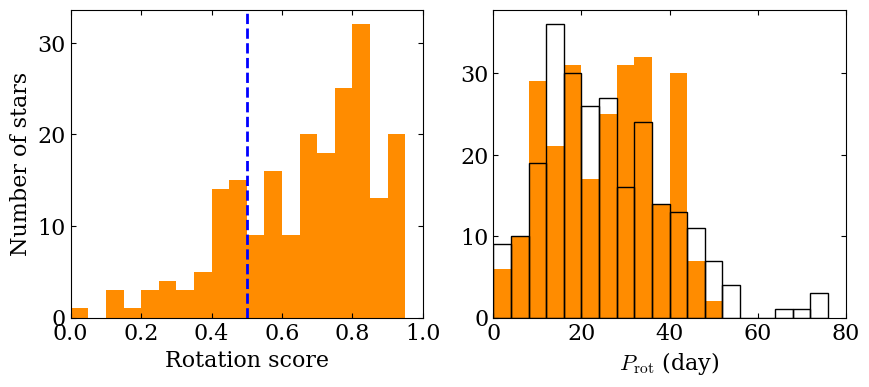

In [20]:
fig, (ax1, ax2) = plt.subplots (1, 2, figsize=(10, 4))

bins = np.linspace (0, 1, 20, endpoint=False)
ax1.hist (rotation_score, bins=bins, color='darkorange')
ax1.axvline (0.5, ls='--', color='blue', lw=2)
bins = np.linspace (0, 80, 20, endpoint=False)
ax2.hist (prot, bins=bins, color='darkorange')
ax2.hist (prot_ref, bins=bins, facecolor='none',
         edgecolor='black', label='Ref')

ax1.set_ylabel (r'Number of stars')
ax1.set_xlabel (r'Rotation score')
ax2.set_xlabel (r'$P_\mathrm{rot}$ (day)')

ax1.set_xlim (0, 1)
ax2.set_xlim (0, 80)